<a href="https://colab.research.google.com/github/sugi-san/sber-swap/blob/main/FaceSwap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

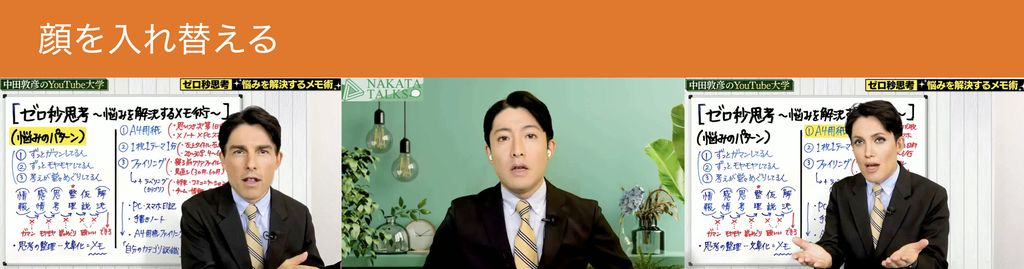

In [ ]:
#@title **1.セットアップ**（数分くらい掛かります）

# Clone github 
!git clone https://github.com/sugi-san/sber-swap.git
%cd sber-swap

# load arcface
!wget -P ./arcface_model https://github.com/sberbank-ai/sber-swap/releases/download/arcface/backbone.pth
!wget -P ./arcface_model https://github.com/sberbank-ai/sber-swap/releases/download/arcface/iresnet.py

# load landmarks detector
!wget -P ./insightface_func/models/antelope https://github.com/sberbank-ai/sber-swap/releases/download/antelope/glintr100.onnx
!wget -P ./insightface_func/models/antelope https://github.com/sberbank-ai/sber-swap/releases/download/antelope/scrfd_10g_bnkps.onnx

# load model itself
!wget -P ./weights https://github.com/sberbank-ai/sber-swap/releases/download/sber-swap-v2.0/G_unet_2blocks.pth

# load super res model
!wget -P ./weights https://github.com/sberbank-ai/sber-swap/releases/download/super-res/10_net_G.pth

# Install required libraries
!pip install mxnet-cu101mkl
!pip install onnxruntime-gpu==1.8
!pip install insightface==0.2.1
!pip install kornia==0.5.4

# library import
import cv2
import torch
import time
import os
from utils.inference.image_processing import crop_face, get_final_image, show_images
from utils.inference.video_processing import read_video, get_target, get_final_video, add_audio_from_another_video, face_enhancement
from utils.inference.core import model_inference
from network.AEI_Net import AEI_Net
from coordinate_reg.image_infer import Handler
from insightface_func.face_detect_crop_multi import Face_detect_crop
from arcface_model.iresnet import iresnet100
from models.pix2pix_model import Pix2PixModel
from models.config_sr import TestOptions


# --- Initialize models ---
app = Face_detect_crop(name='antelope', root='./insightface_func/models')
app.prepare(ctx_id= 0, det_thresh=0.6, det_size=(640,640))

# main model for generation
G = AEI_Net(backbone='unet', num_blocks=2, c_id=512)
G.eval()
G.load_state_dict(torch.load('weights/G_unet_2blocks.pth', map_location=torch.device('cpu')))
G = G.cuda()
G = G.half()

# arcface model to get face embedding
netArc = iresnet100(fp16=False)
netArc.load_state_dict(torch.load('arcface_model/backbone.pth'))
netArc=netArc.cuda()
netArc.eval()

# model to get face landmarks
handler = Handler('./coordinate_reg/model/2d106det', 0, ctx_id=0, det_size=640)

# model to make superres of face, set use_sr=True if you want to use super resolution or use_sr=False if you don't
use_sr = True
if use_sr:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    torch.backends.cudnn.benchmark = True
    opt = TestOptions()
    #opt.which_epoch ='10_7'
    model = Pix2PixModel(opt)
    model.netG.train()

# warning
import warnings
warnings.simplefilter('ignore')

# import function
from function import *

# make folder
import os
os.makedirs('download', exist_ok=True)

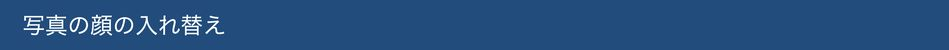

In [ ]:
#@title **2.写真の表示**
display_pic('examples/images')

In [ ]:
#@title **3.顔の入れ替え（写真）**
source_img = '02.jpg' #@param {type:"string"}
target_img = '01.jpg' #@param {type:"string"}
source_path = 'examples/images/'+source_img
target_path = 'examples/images/' + target_img

source_full = cv2.imread(source_path)
crop_size = 224 # don't change this
batch_size =  40

source = crop_face(source_full, app, crop_size)[0]
source = [source[:, :, ::-1]]

target_full = cv2.imread(target_path)
full_frames = [target_full]
target = get_target(full_frames, app, crop_size)

final_frames_list, crop_frames_list, full_frames, tfm_array_list = model_inference(full_frames,
                                                                                   source,
                                                                                   target,
                                                                                   netArc,
                                                                                   G,
                                                                                   app,
                                                                                   set_target = False,
                                                                                   crop_size=crop_size,
                                                                                   BS=batch_size)

result = get_final_image(final_frames_list, crop_frames_list, full_frames[0], tfm_array_list, handler)
cv2.imwrite('examples/results/result.png', result)

In [ ]:
#@title **4.画像の表示**
import matplotlib.pyplot as plt

show_images([source[0][:, :, ::-1], target_full, result], ['Source Image', 'Target Image', 'Swapped Image'], figsize=(20, 15))

In [ ]:
#@title **5.画像のダウンロード**
import shutil
source_name = os.path.splitext(source_img)
target_name = os.path.splitext(target_img)
download_name = 'download/'+source_name[0]+'_'+target_name[0]+'.png'
shutil.copy('examples/results/result.png', download_name)

from google.colab import files
files.download(download_name)

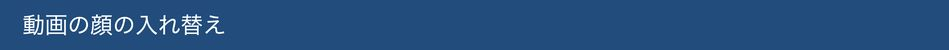

In [ ]:
#@title **6.写真と動画の表示**

# --- 画像表示 ---
print('=== images ===')
display_pic('examples/images')

# --- 動画表示 ---
print('=== videos ===')
reset_folder('pic')
files = sorted(os.listdir('examples/videos'))
for file in files:
  save_frame(file)
display_movie('pic', files)

In [ ]:
#@title **7.顔の入れ替え（動画）**
source_img = '05.jpg' #@param {type:"string"}
video = '01.mp4' #@param {type:"string"}
source_path = 'examples/images/'+source_img
path_to_video = 'examples/videos/'+video

source_full = cv2.imread(source_path)
OUT_VIDEO_NAME = "examples/results/result.mp4"
crop_size = 224 # don't change this
batch_size =  40

source = crop_face(source_full, app, crop_size)[0]
source = [source[:, :, ::-1]]

full_frames, fps = read_video(path_to_video)
target = get_target(full_frames, app, crop_size)

START_TIME = time.time()

final_frames_list, crop_frames_list, full_frames, tfm_array_list = model_inference(full_frames,
                                                                                   source,
                                                                                   target,
                                                                                   netArc,
                                                                                   G,
                                                                                   app,
                                                                                   set_target = False,
                                                                                   crop_size=crop_size,
                                                                                   BS=batch_size)

if use_sr:
    final_frames_list = face_enhancement(final_frames_list, model)

get_final_video(final_frames_list,
                crop_frames_list,
                full_frames,
                tfm_array_list,
                OUT_VIDEO_NAME,
                fps, 
                handler)
  
add_audio_from_another_video(path_to_video, OUT_VIDEO_NAME, "audio")

print(f'Full pipeline took {time.time() - START_TIME}')
print(f"Video saved with path {OUT_VIDEO_NAME}")


In [ ]:
#@title **8.動画を表示**
display_mp4('examples/results/result.mp4')

In [ ]:
#@title **9.動画のダウンロード**
import shutil
source_name = os.path.splitext(source_img)
video_name = os.path.splitext(video)
download_name = 'download/'+source_name[0]+'_'+video_name[0]+'.mp4'
shutil.copy('examples/results/result.mp4', download_name)

from google.colab import files
files.download(download_name)

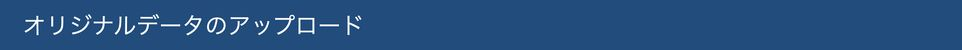

In [ ]:
#@title **10.データアップロード**
#@markdown ・selectで写真（images）か動画（videos）を選択して下さい）\
#@markdown ・動画はHD以下、20秒以内にして下さい
import os
import shutil
from google.colab import files
import cv2

select = 'videos' #@param ["images", "videos"]

# ルートへ画像をアップロード
uploaded = files.upload()           
uploaded = list(uploaded.keys())    

# ルートから指定フォルダーへ移動
for file in uploaded:
    shutil.move(file, 'examples/'+select+'/'+file)  


###【備考】
・ブラウザは、必ずGoogle Chromeを使用して下さい。

・動作がおかしくなった場合の対応\
１）グーグルクロームの該当タブを削除して接続を切る\
２）再度リンクを開く\
３）右上にある「ランタイム／ランタイムを出荷時設定にリセット」をクリックする（下記写真を参照に下さい）\
４）あとは、動画にある通りの操作をすればOK

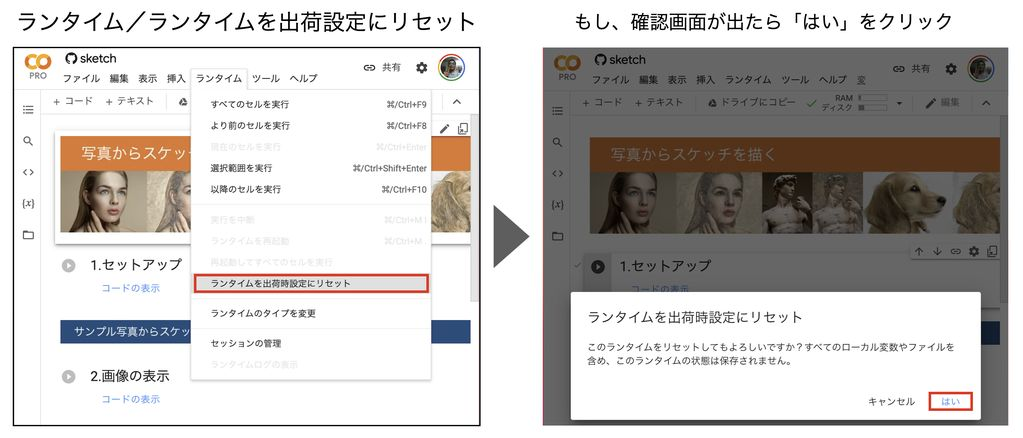